# DWT-DCT-SVD Watermarking Demo (Non-Blind)
Trong notebook này, chúng ta thực hiện quá trình nhúng watermark vào ảnh màu và trích xuất lại watermark bằng phương pháp **DWT-DCT-SVD** (Non-Blind).

In [63]:
# Imports
import os
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

plt.rcParams['figure.figsize'] = [12,6]

# Utilities funtion to compare image
def nc(wm_original, wm_extracted):
    wm_original = wm_original.astype(np.float32).flatten()
    wm_extracted = wm_extracted.astype(np.float32).flatten()
    wm_original -= np.mean(wm_original)
    wm_extracted -= np.mean(wm_extracted)
    num = np.sum(wm_original * wm_extracted)
    den = np.sqrt(np.sum(wm_original**2) * np.sum(wm_extracted**2))
    return max(0.0, min(1.0, num/den)) if den != 0 else 0.0

# | PSNR (dB) | Nhận xét về chất lượng ảnh                                     |
# | --------- | -------------------------------------------------------------- |
# | > 40      | Rất cao → hầu như **không nhận thấy khác biệt** với mắt thường |
# | 30 – 40   | Cao → **khác biệt rất nhẹ**, chỉ chú ý khi soi kỹ              |
# | 20 – 30   | Trung bình → **ảnh nhìn thấy khác biệt rõ**                    |
# | < 20      | Thấp → **ảnh biến dạng mạnh**, chất lượng giảm nhiều           |

def psnr(a, b):
    return cv2.PSNR(a, b)



## Core functions: DCT, IDCT, Embed & Extract

In [64]:
def dct2(block):
    return cv2.dct(block)

def idct2(block):
    return cv2.idct(block)

def embed_dwt_dct_svd(cover_color, watermark, alpha=0.3, wavelet='haar', k_embed=30):
    ycrcb = cv2.cvtColor(cover_color, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_f = np.float32(y)

    LL, (LH, HL, HH) = pywt.dwt2(y_f, wavelet)
    dct_LL = dct2(LL)
    Uc, Sc, Vc = np.linalg.svd(dct_LL, full_matrices=False)

    wm_resized = cv2.resize(watermark, (dct_LL.shape[1], dct_LL.shape[0])).astype(np.float32)
    Uw, Sw, Vw = np.linalg.svd(wm_resized, full_matrices=False)

    k = min(k_embed, len(Sc), len(Sw))
    Sc_mod = Sc.copy()
    Sc_mod[:k] += alpha * Sw[:k]

    dct_LL_mod = Uc @ np.diag(Sc_mod) @ Vc
    LL_mod = idct2(dct_LL_mod)
    y_wm = pywt.idwt2((LL_mod, (LH, HL, HH)), wavelet)
    y_wm = np.uint8(np.clip(y_wm[:y.shape[0], :y.shape[1]], 0, 255))
    watermarked_color = cv2.cvtColor(cv2.merge((y_wm, cr, cb)), cv2.COLOR_YCrCb2BGR)

    meta = {
        'wavelet': wavelet,
        'Uw': Uw[:, :k],
        'Vw': Vw[:k, :],
        'Sc': Sw[:k],
        'original_wm_shape': watermark.shape,
    }
    return watermarked_color, meta


def extract_dwt_dct_svd(cover_color, watermarked_color, meta, alpha=0.3):
    wavelet = meta['wavelet']
    Uw, Vw, Sc = meta['Uw'], meta['Vw'], meta['Sc']
    cover_y = cv2.cvtColor(cover_color, cv2.COLOR_BGR2YCrCb)[:, :, 0].astype(np.float32)
    wtr_y = cv2.cvtColor(watermarked_color, cv2.COLOR_BGR2YCrCb)[:, :, 0].astype(np.float32)
    LL_c, (LH_c, HL_c, HH_c) = pywt.dwt2(cover_y, wavelet)
    LL_m, (LH_m, HL_m, HH_m) = pywt.dwt2(wtr_y, wavelet)
    dct_LL_c = dct2(LL_c)
    dct_LL_m = dct2(LL_m)
    Sc_c = np.linalg.svd(dct_LL_c, full_matrices=False)[1]
    Sc_m = np.linalg.svd(dct_LL_m, full_matrices=False)[1]
    k = min(len(Sc_c), len(Sc_m), Uw.shape[1])
    Sw_rec = (Sc_m[:k] - Sc_c[:k])/alpha
    wm_rec = Uw[:, :k] @ np.diag(Sw_rec) @ Vw[:k, :]
    wm_rec = wm_rec - wm_rec.min()
    if wm_rec.max() != 0:
        wm_rec = wm_rec / wm_rec.max()
    wm_out = cv2.resize(np.uint8(np.clip(wm_rec*255, 0, 255)), meta['original_wm_shape'][::-1])
    return wm_out

## Demo: Embed watermark

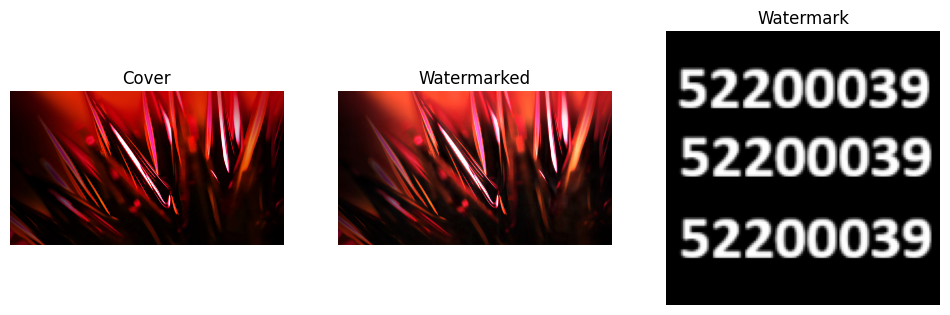

In [65]:
# Paths (put your files in 'input/')
input_dir = 'input'
cover_path = os.path.join(input_dir, 'Nitro_Wallpaper_5000x2813.jpg')
watermark_path = os.path.join(input_dir, 'watermark.png')

cover = cv2.imread(cover_path)
wm = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)
alpha = 0.5

watermarked, meta = embed_dwt_dct_svd(cover, wm, alpha=alpha)

plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(cover, cv2.COLOR_BGR2RGB)); plt.title('Cover'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(watermarked, cv2.COLOR_BGR2RGB)); plt.title('Watermarked'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(wm, cmap='gray'); plt.title('Watermark'); plt.axis('off')
plt.show()

## Extract watermark and compare

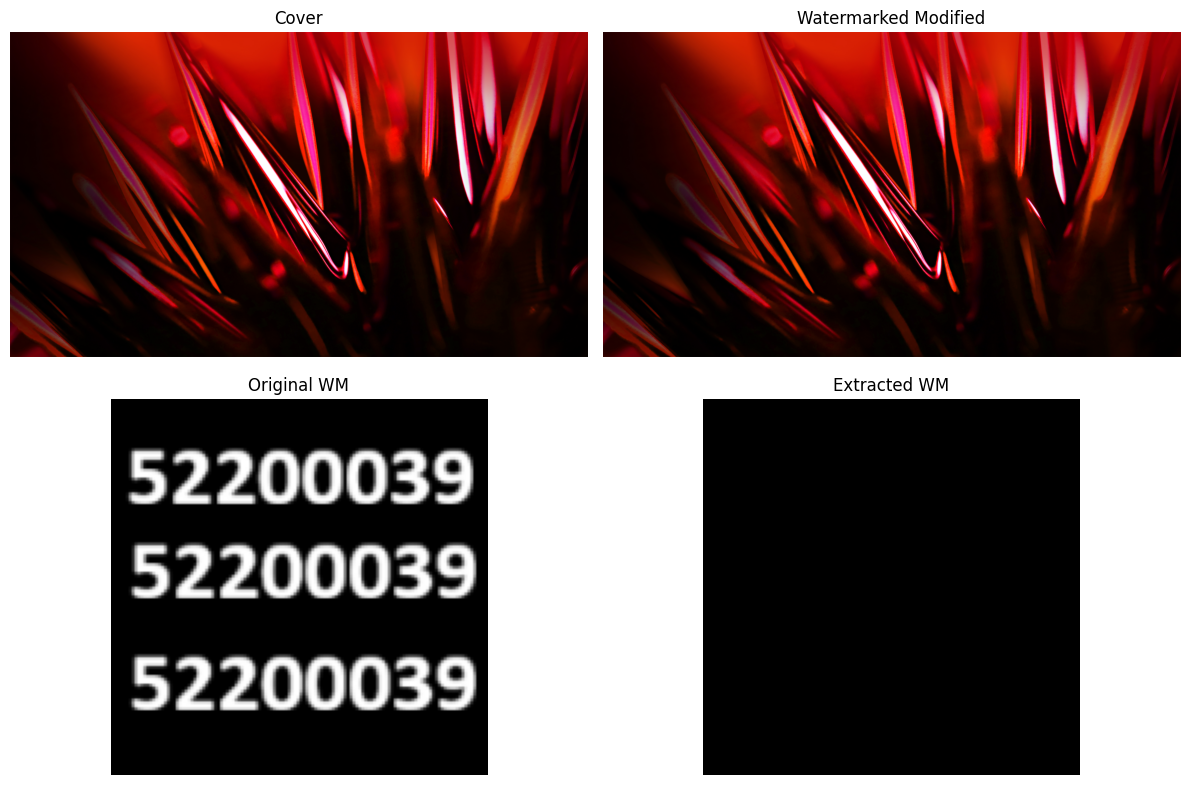

NCC: 0.0000
PSNR cover vs watermarked: 21.2998
PSNR cover vs watermarked_modified (resized): 361.2020


In [67]:


# 1. Giả lập thay đổi (làm mờ, xoay, gây nhiễu, ..) ảnh đã watermark

watermarked_modified = watermarked.copy()
watermarked_modified = cv2.imread(os.path.join(input_dir, 'Nitro_Wallpaper_5000x2813.jpg'))
# Ví dụ: làm mờ Gaussian
# watermarked_modified = cv2.GaussianBlur(watermarked, (11,11), 8)

# # Ví dụ: xoay 15 độ
# center = (watermarked_modified.shape[1]//2, watermarked_modified.shape[0]//2)
# M = cv2.getRotationMatrix2D(center, 9, 1.0)
# watermarked_modified = cv2.warpAffine(watermarked_modified, M, (watermarked_modified.shape[1], watermarked_modified.shape[0]))

# # Ví dụ: thêm nhiễu Gaussian
# noise = np.random.normal(0, 8, watermarked_modified.shape).astype(np.uint8)
# watermarked_modified = cv2.add(watermarked_modified, noise)

# h, w = watermarked_modified.shape[:2]

# # # crop 80% chiều cao và 80% chiều rộng từ góc trên-trái
# crop_h = int(h * 0.8)
# crop_w = int(w * 0.8)

# start_y = 0
# start_x = 0
# end_y = start_y + crop_h
# end_x = start_x + crop_w

# watermarked_modified = watermarked_modified[start_y:end_y, start_x:end_x]



# 2. Trích xuất watermark từ ảnh đã biến đổi
extracted = extract_dwt_dct_svd(cover, watermarked_modified, meta, alpha=alpha)

# 3. Hiển thị cover, watermarked_modified, watermark gốc và watermark trích xuất
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(cover, cv2.COLOR_BGR2RGB))
plt.title('Cover')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(cv2.cvtColor(watermarked_modified, cv2.COLOR_BGR2RGB))
plt.title('Watermarked Modified')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(wm, cmap='gray')
plt.title('Original WM')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(extracted, cmap='gray')
plt.title('Extracted WM')
plt.axis('off')

plt.tight_layout()
plt.show()

# So sánh watermark gốc vs trích xuất
print(f'NCC: {nc(wm, extracted):.4f}')

try:
    s = psnr(cover, watermarked)
    print(f'PSNR cover vs watermarked: {s:.4f}')
except Exception as e:
    print('PSNR error:', e)

try:
    watermarked_resized = cv2.resize(watermarked_modified, (cover.shape[1], cover.shape[0]), interpolation=cv2.INTER_LINEAR)
    s = psnr(cover, watermarked_resized)
    print(f'PSNR cover vs watermarked_modified (resized): {s:.4f}')
except Exception as e:
    print('PSNR error:', e)


